#Análise de Sentimentos

Ajustar o BERT para análise de sentimento utilizando a biblioteca de Transformers da Hugging Face.

Seguiremos os seguintes passos:

- Pré-processar dados de texto para BERT e construir conjunto de dados PyTorch (tokenização, máscaras de atenção e *padding*)
- Usar *transfer learning* para construir um classificador de sentimentos usando a biblioteca Transformers da Hugging Face
- Avaliar o modelo em dados de teste
- Prever o sentimento no texto bruto

In [1]:
!pip install -q -U watermark
!pip install -qq transformers[sentencepiece]
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 20.3 MB/s eta 0:00:00
Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy                      : 1.23.5
pandas                     : 1.5.3
torch                      : 2.1.0+cu118
transformers[sentencepiece]: not installed



In [2]:
#@title ##Pacotes e configurações
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 6, 4

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

##Carga e exploração dos dados

Vamos carregar o conjunto de dados com as *reviews* do aplicativo Google Play.


In [3]:
!gdown 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 115MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 63.9MB/s]


In [4]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [5]:
df.shape

(15746, 11)

Temos aproximadamente 16k exemplos. Vamos checar os valores ausentes:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


A distribuição de classes é balanceada?

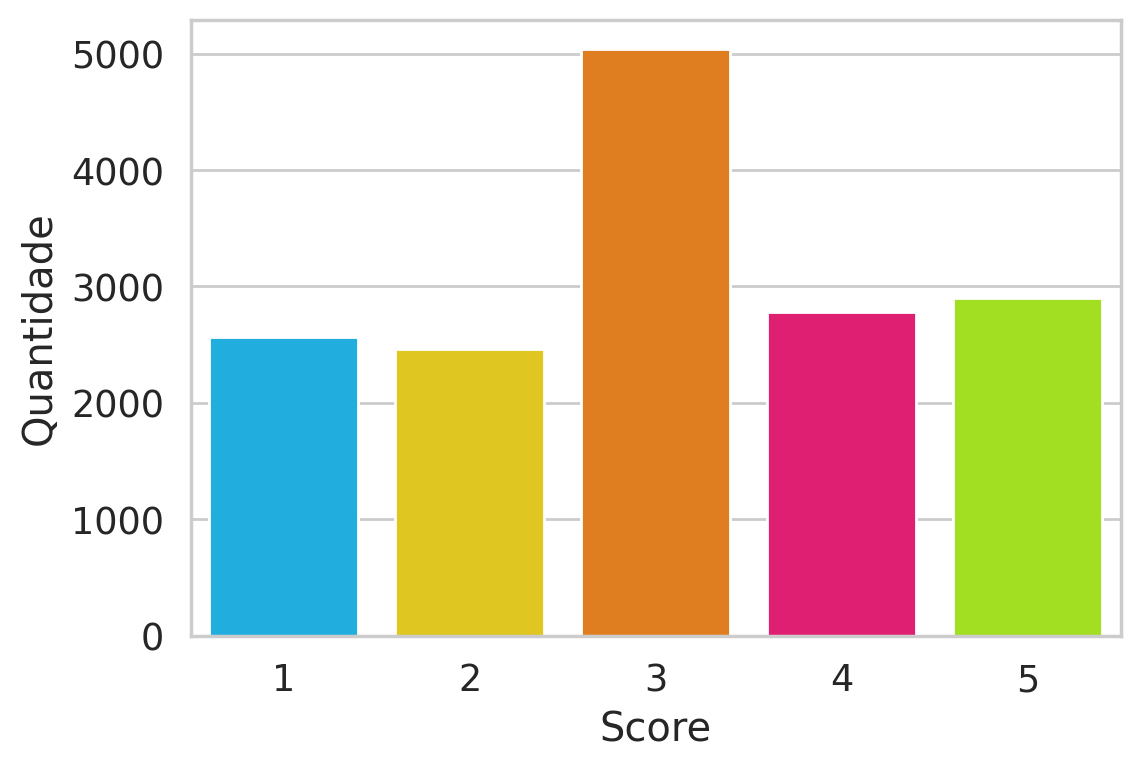

In [7]:
sns.countplot(data=df, x = df.score)
plt.ylabel('Quantidade')
plt.xlabel('Score');

Há um desbalanceamento, mas tudo bem. Vamos converter o dataset para sentimentos negativo, neutro e positivo:

In [8]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2: # negativo
    return 0
  elif rating == 3: # neutro
    return 1
  else:
    return 2 # positivo

df['sentiment'] = df.score.apply(to_sentiment)

In [9]:
class_names = ['negativo', 'neutro', 'positivo']

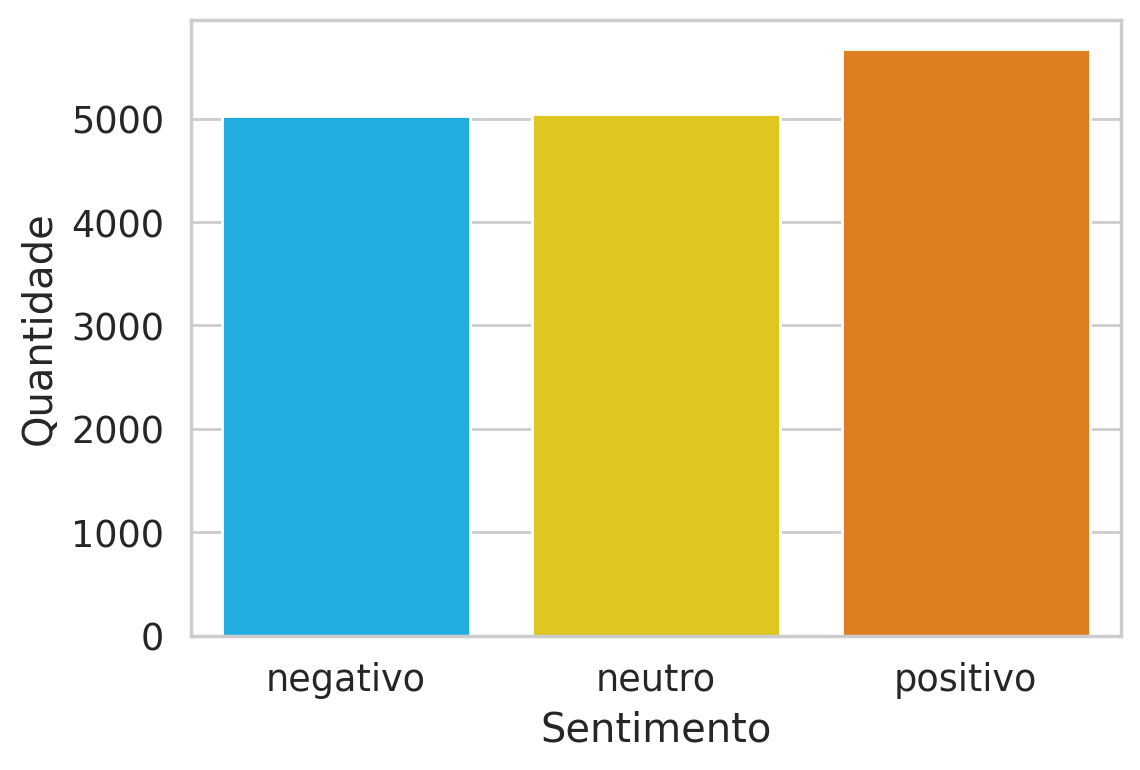

In [10]:
ax = sns.countplot(data=df, x=df.sentiment)
plt.ylabel('Quantidade')
plt.xlabel('Sentimento');
ax.set_xticklabels(class_names);

O dataset está praticamente balanceado.

##Pré-processamento de dados

Sabemos que os algoritmos de AM não trabalham diretamente com textos brutos. Assim, precisamos converter os textos em números. O BERT ainda exige alguns requisitos específicos:

- Adicionar *tokens* especiais para separar sentenças e realizar a classificação
- Passar sequências de comprimento/tamanho fixo: introduzir padding(preenchimento)
- Criar uma matriz de 0s (*pad token*) e 1s (*real token*) chamada *máscara de atenção*

A biblioteca Transformers oferece uma ampla variedade de modelos de Transformers (incluindo BERT). Funciona com TensorFlow e PyTorch! Também inclui tokenizadores pré-construídos que fazem esse trabalho "pesado".

In [11]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
# Opções: https://huggingface.co/transformers/v3.3.1/pretrained_models.html

> Podemos usar uma versão *case sensitive* ou não do BERT e do tokenizador. A versão *case sensitive* deve funcionar melhor pois, por exemplo, espera-se que “RUIM” transmita mais sentimento do que “ruim”.


Carregando um tokenizador pré-treinador [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [12]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Relembrando o processo de tokenização.

In [13]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

Algumas operações básicas podem ser usadas para converter o texto em *tokens* e os tokens em identificadores únicos (ids).

In [14]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentença: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'      IDs: {token_ids}')

 Sentença: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
      IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


### *Tokens* especiais

`[SEP]` - marcador de final de sentença


In [15]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - marcador de início de sentença

In [16]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

*Padding*.

In [17]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT reconhece os *tokens* usados no treinamento. Todo o resto pode ser codificado usando o *token* `[UNK]` (*unknown*)

In [18]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

Tudi isso pode ser feito utilizando [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [19]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

Os IDs dos *tokens* agora são armazenados em um Tensor e preenchidos até um comprimento de 32.

In [20]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

A máscara de atenção tem o mesmo comprimento:

In [21]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

Podemos inverter a tokenização para dar uma olhada nos *tokens* especiais:

In [22]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Escolhendo o comprimento da sequência

BERT trabalha com sequências de comprimento fixo. Usaremos uma estratégia simples para escolher o comprimento máximo. Vamos armazenar o comprimento do *token* de cada revisão e plotar a distribuição.

In [23]:
token_lens = []
for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


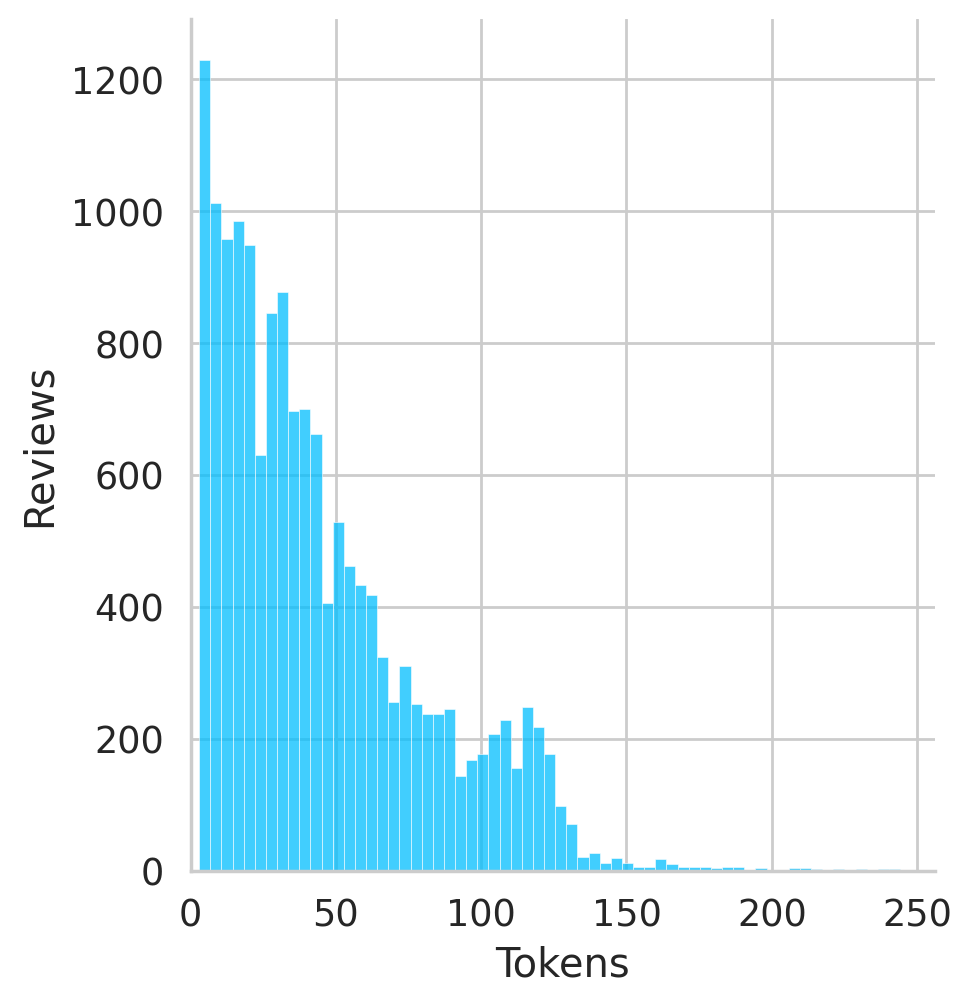

In [24]:
sns.displot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Tokens');
plt.ylabel('Reviews');

A maioria das *reviews* parece conter menos de 128 *tokens*.

In [25]:
MAX_LEN = 128

Temos todos os blocos de construção necessários para criar um conjunto de dados PyTorch. Vamos fazê-lo:


In [26]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #pad_to_max_length=True,
      padding='max_length', ## incluido
      truncation=True,  ## incluido
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

O tokenizador está fazendo a maior parte do trabalho "pesado". Também retornamos os textos de revisão, assim será mais fácil avaliar as previsões do  modelo. Vamos dividir os dados:

In [27]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [28]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

Também precisamos criar alguns carregadores de dados. Aqui está uma função auxiliar para fazer isso.

In [29]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [30]:
BATCH_SIZE = 64

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Vamos dar uma olhada em um lote de exemplo do nosso carregador de dados de treinamento:

In [31]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [32]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64])


## Classificação de sentimentos utilizando BERT e Hugging Face

Em vez de utilizar o modelo pronto [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), vamos utilizar o [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) básico e construir nosso classificador de sentimento sobre ele.

Vamos carregar o modelo e tenter usá-lo na codificação do nosso texto de exemplo.

In [33]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [34]:
outputs = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)
last_hidden_state = outputs[0]
pooled_output = outputs[1]

Creiando um classificador que usa o modelo BERT.

In [35]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,return_dict=False # return_dict=False added
    )
    output = self.drop(pooled_output)
    return self.out(output)

Nosso classificador delega a maior parte do trabalho pesado ao BertModel. Usamos uma camada *dropout* para alguma regularização e uma camada totalmente conectada para nossa saída. Observe que estamos retornando a saída bruta da última camada, pois isso é necessário para que a função *loss* (perda) de entropia cruzada no PyTorch funcione.

Isso deve funcionar como qualquer outro modelo PyTorch. Vamos criar uma instância e movê-la para a GPU.

In [36]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Moveremos o lote de exemplo de nossos dados de treinamento para a GPU:

In [37]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([64, 128])
torch.Size([64, 128])


Para obter as probabilidades previstas do modelo treinado, aplicamoss a função *softmax* às saídas.

In [38]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2332, 0.4717, 0.2951],
        [0.2219, 0.3612, 0.4168],
        [0.3295, 0.2760, 0.3945],
        [0.2221, 0.3218, 0.4561],
        [0.5762, 0.2056, 0.2181],
        [0.2249, 0.4422, 0.3329],
        [0.2750, 0.3181, 0.4069],
        [0.3732, 0.2454, 0.3813],
        [0.3927, 0.1892, 0.4181],
        [0.3349, 0.1948, 0.4703],
        [0.3043, 0.2263, 0.4695],
        [0.3710, 0.1894, 0.4396],
        [0.2090, 0.4449, 0.3462],
        [0.3396, 0.2594, 0.4010],
        [0.3456, 0.2260, 0.4284],
        [0.1500, 0.3302, 0.5198],
        [0.1845, 0.2860, 0.5294],
        [0.2734, 0.3109, 0.4157],
        [0.2281, 0.3393, 0.4326],
        [0.4347, 0.2083, 0.3570],
        [0.3614, 0.2068, 0.4318],
        [0.4479, 0.2123, 0.3399],
        [0.4260, 0.2630, 0.3110],
        [0.1974, 0.3333, 0.4693],
        [0.2323, 0.3263, 0.4414],
        [0.1917, 0.4365, 0.3718],
        [0.3085, 0.3649, 0.3266],
        [0.3544, 0.3311, 0.3146],
        [0.4750, 0.1858, 0.3392],
        [0.293

###Treinamento

In [39]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False,no_deprecation_warning=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Alguns hiper-parâmetros recomendados pelos autores do BERT para o ajuste fino:

- *Batch size*: 16, 32
- Taxa de aprendizado (Adam): 5e-5, 3e-5, 2e-5
- Número de épocas: 2, 3, 4

Importante destacar que aumentar o *batch size* reduz o tempo de treinamento (por época), porém produz uma acurácia menor (por época).

Função para treinar o modelo por uma época.

In [40]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


Função de avaliação do modelo a partir de um *data loader*.

In [41]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Utilizando as duas funções anteriores para treinar e avaliar o modelo

In [42]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.8451706301253121 accuracy 0.5810457977559805
Val   loss 0.611112117767334 accuracy 0.7369758576874206

Epoch 2/10
----------
Train loss 0.5168425366282463 accuracy 0.788158916096253
Val   loss 0.5406548862273877 accuracy 0.8043202033036849

Epoch 3/10
----------
Train loss 0.31145230157149806 accuracy 0.8846940935713782
Val   loss 0.5455046800466684 accuracy 0.818297331639136

Epoch 4/10
----------
Train loss 0.18643098216302492 accuracy 0.9355726483663821
Val   loss 0.5076267008598034 accuracy 0.8678526048284626

Epoch 5/10
----------
Train loss 0.12372441255479111 accuracy 0.9583656763813422
Val   loss 0.5236397568996136 accuracy 0.8703939008894537

Epoch 6/10
----------
Train loss 0.09071896882593497 accuracy 0.9681744407592972
Val   loss 0.6102013565026797 accuracy 0.8792884371029225

Epoch 7/10
----------
Train loss 0.07557809449153373 accuracy 0.9752311057794086
Val   loss 0.6415206835820124 accuracy 0.8856416772554003

Epoch 8/10
----------
Tra

O melhor modelo foi escolhido com base na acurácia de validação.

In [43]:
cpu_train_acc = [x.cpu() for x in history['train_acc']]
cpu_val_acc = [x.cpu() for x in history['val_acc']]

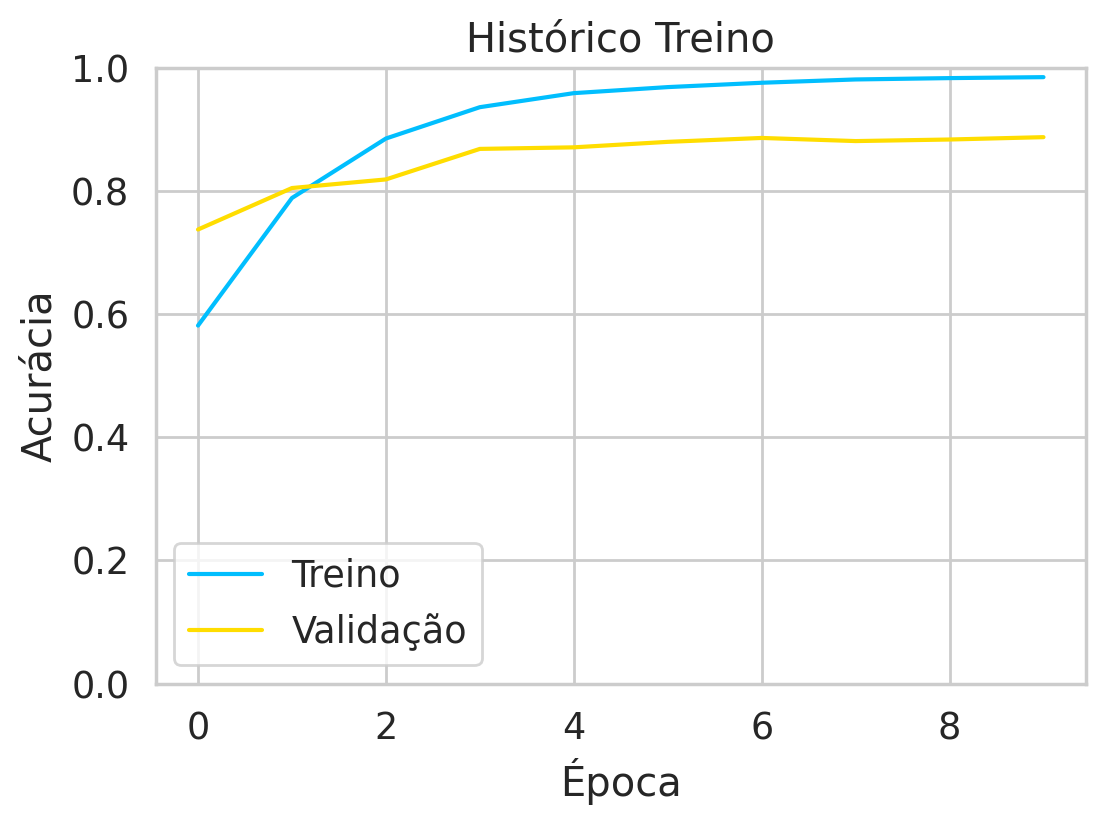

In [44]:
plt.plot(cpu_train_acc, label='Treino')
plt.plot(cpu_val_acc, label='Validação')

plt.title('Histórico Treino')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend()

plt.ylim([0, 1]);

A acurácia de treinamento começa a se aproximar de 100% após cerca de 10 épocas.

Se não quiser esperar o tempo de treinamento, descomente o trecho de código abaixo para baixar um modelo pré-treinado.

In [ ]:
# !gdown 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model2 = SentimentClassifier(len(class_names))
# model2.load_state_dict(torch.load('best_model_state.bin'))
# model2 = model2.to(device)

## Avaliação

Quão bom ficou nosso classificador de sentimentos?

In [45]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8845177664974618

Função para utilizar o modelo para previsão.

In [46]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

Semelhante à função de avaliação, exceto que armazenamos o texto das revisões e as probabilidades previstas (aplicando *softmax* nos resultados do modelo):

In [47]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Resultados da avaliação.

In [48]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negativo       0.91      0.84      0.88       245
      neutro       0.81      0.87      0.84       254
    positivo       0.93      0.93      0.93       289

    accuracy                           0.88       788
   macro avg       0.89      0.88      0.88       788
weighted avg       0.89      0.88      0.88       788



É possível notar que é realmente difícil classificar avaliações neutras (3 estrelas), o que, de fato, faz muito sentido. Como nós faríamos para "sair de cima do muro"?

Vamos dar uma olhada na matriz de confusão.


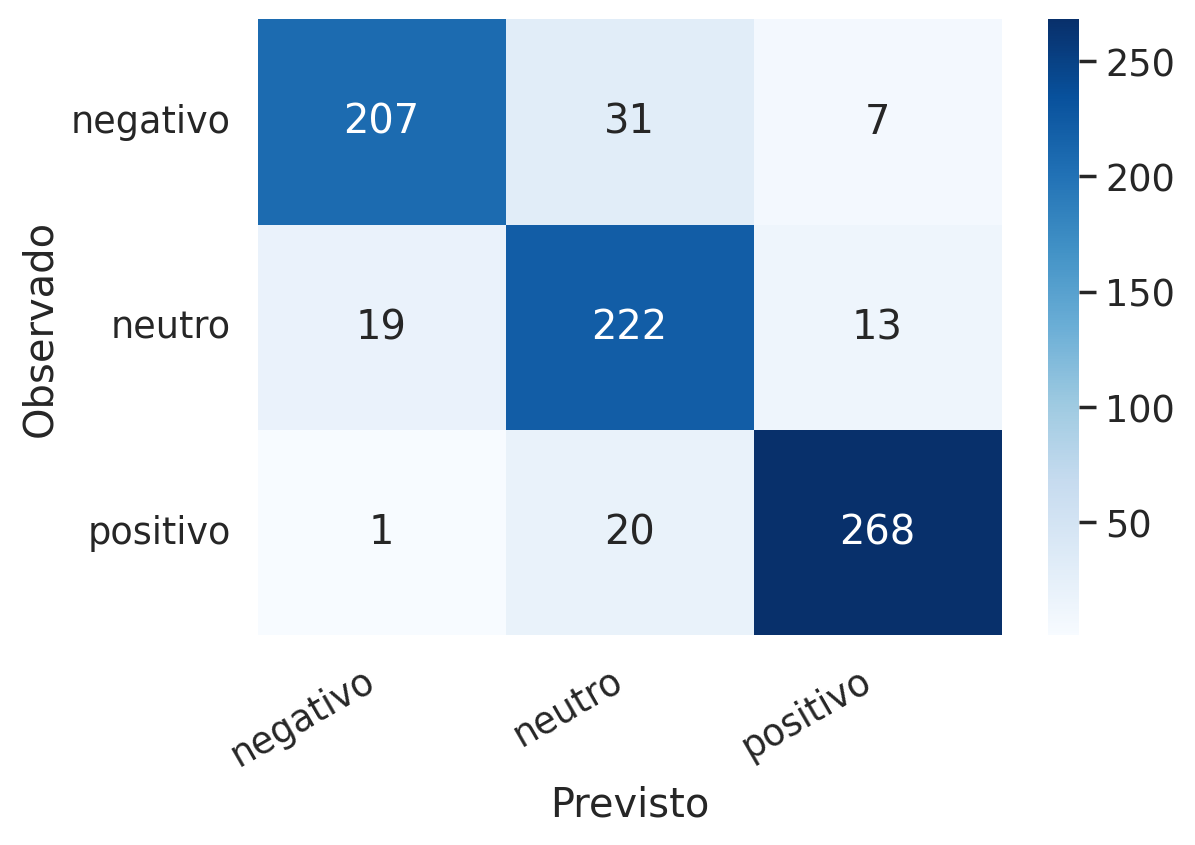

In [49]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Observado')
  plt.xlabel('Previsto');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Ela confirma que o modelo está tendo dificuldade em classificar avaliações neutras. Ele os confunde com negativos e positivos em uma frequência aproximadamente igual.

Essa é uma boa visão geral do desempenho do modelo. Mas vamos dar uma olhada em um exemplo de nossos dados de teste.

In [50]:
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
predict_sentiment = y_pred[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [51]:
print("\n".join(wrap(review_text)))
print()
print(f'Sentimento real   : {class_names[true_sentiment]}')
print(f'Sentimento predito: {class_names[predict_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

Sentimento real   : neutro
Sentimento predito: neutro


### Previsão a partir de texto


In [52]:
review_text = "I love completing my todos! Best app ever!!!"

Temos que utilizar o tokenizer para codificar o texto.

In [53]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  #pad_to_max_length=True,
  padding='max_length', ## incluido
  truncation=True,  ## incluido
  return_attention_mask=True,
  return_tensors='pt',
)

Obtendo a predição do modelo.

In [54]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review: {review_text}')
print(f'Sentimento: {class_names[prediction]}')

Review: I love completing my todos! Best app ever!!!
Sentimento: positivo
